In [1]:
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import inspect
import numpy as np
import matplotlib.pyplot as plt

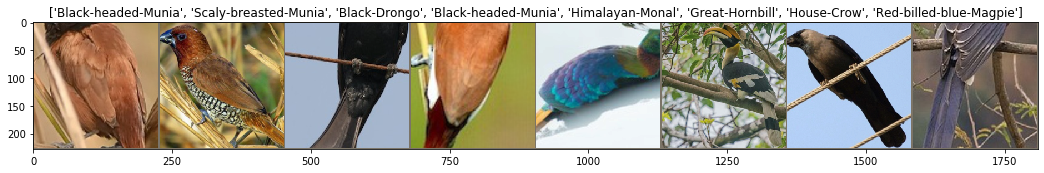

In [9]:
#Inception net takes input of 299X299 pixels
compose = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

compose_test = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = ImageFolder('Birds_data/train', transform=compose)
test = ImageFolder('Birds_data/test', transform=compose_test)
train_loader = DataLoader(train, batch_size=20, shuffle=True)
test_loader = DataLoader(test, batch_size=20, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.subplots(figsize=(18,13))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
display = True
if display:
    out = torchvision.utils.make_grid(inputs[:8])
    class_names = test.classes
    imshow(out, title=[class_names[x] for x in classes[:8]])


In [5]:
# import vgg16
n_inputs = 4096
n_classes = 10

transfer_model = models.vgg16(pretrained=True, progress=True)

'''
Since we will be using the pretrained model weights we will only remove the final output layer which currently has around 1000 outputs
and replace with a fully connected layer with ten outputs. We will also freeze the weights of the rest of the layers 
'''
for params in transfer_model.parameters():
    params.requires_grad = False #makes sure that weights are not updated during the training

#Get the number of inputs for the final layer
# Add on classifier
transfer_model.classifier[6] = nn.Sequential(
                                              nn.Linear(n_inputs, 256), 
                                              nn.ReLU(), 
                                              nn.Dropout(0.4),
                                              nn.Linear(256, n_classes),                   
                                              nn.LogSoftmax(dim=1))

print(transfer_model.classifier)
transfer_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=transfer_model.parameters(), lr=.0001, momentum=0.9)

#Reduce learning rate lr by a factor of 0.1 every 7 epochs

step_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): LogSoftmax()
  )
)


In [6]:
print(device)

cuda:0


In [7]:
nb_epochs = 10

sigmoid = nn.Sigmoid()
test_loss_epoch = []
test_accuracy = []
train_loss_epoch = []
train_accuracy = []
for epoch in range(nb_epochs):
    train_acc = 0
    test_acc = 0
    train_loss = []
    test_loss = []
    
    transfer_model.train()
    with torch.set_grad_enabled(True):
        for i, (images, labels) in enumerate(train_loader):
            inputs = images.to(device)
            targets = labels.to(device)

            #Zero all gradients
            optimizer.zero_grad()

            #Forward pass

#             output, _ = transfer_model(inputs)
            output = transfer_model(inputs)
            #Compute binary cross entropy loss
            loss = criterion(output, targets)
            _, pred = torch.max(output, 1)


            train_acc += torch.sum(targets == pred)

            #Backpropagate
            loss.backward()
            #Update parameters that requires grad
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
            if i%10 == 0:
                print('Iteration {} in Epoch {} Train Loss: {}'.format(i, epoch, loss))
    transfer_model.eval()
    with torch.set_grad_enabled(False):
        for i, (images, labels) in enumerate(test_loader):
            inputs_test = images.to(device)
            targets_test = labels.to(device)

            output = transfer_model(inputs_test)
            # Compute cross entropy loss
            loss_test = criterion(output, targets_test)
            _, pred = torch.max(output, 1)
            test_acc += torch.sum(targets_test == pred)
            test_loss.append(loss_test.detach().cpu().numpy())
    #Change learning rate every seven epochs
    step_lr.step()


    train_loss_epoch.append(sum(train_loss)/len(train_loader))
    test_loss_epoch.append(sum(test_loss)/len(test_loader))
    train_accuracy.append(train_acc.cpu().numpy()/len(train))
    test_accuracy.append(test_acc.cpu().numpy()/len(test))
    print('Epoch: {}, Train Loss: {} Train Accuracy: {}// Test Loss: {} Test Accuracy: {}'.format(epoch, sum(train_loss)/len(train_loader), train_acc.cpu().numpy()/len(train), sum(test_loss)/len(test_loader), test_acc.cpu().numpy()/len(test)))



Iteration 0 in Epoch 0 Train Loss: 2.4425666332244873
Iteration 10 in Epoch 0 Train Loss: 2.3933660984039307
Iteration 20 in Epoch 0 Train Loss: 2.27887225151062
Iteration 30 in Epoch 0 Train Loss: 2.247227430343628
Iteration 40 in Epoch 0 Train Loss: 2.044656991958618
Iteration 50 in Epoch 0 Train Loss: 2.104273796081543
Iteration 60 in Epoch 0 Train Loss: 2.1637606620788574
Iteration 70 in Epoch 0 Train Loss: 2.0766971111297607
Iteration 80 in Epoch 0 Train Loss: 2.2244770526885986
Iteration 90 in Epoch 0 Train Loss: 2.1472115516662598
Iteration 100 in Epoch 0 Train Loss: 2.09299373626709
Iteration 110 in Epoch 0 Train Loss: 2.152061939239502
Iteration 120 in Epoch 0 Train Loss: 1.9569677114486694
Epoch: 0, Train Loss: 2.204519877066979 Train Accuracy: 0.1994577846630519// Test Loss: 1.9499409119288127 Test Accuracy: 0.7033333333333334
Iteration 0 in Epoch 1 Train Loss: 1.8881088495254517
Iteration 10 in Epoch 1 Train Loss: 2.0843517780303955
Iteration 20 in Epoch 1 Train Loss: 1.979

In [7]:
torch.cuda.empty_cache()

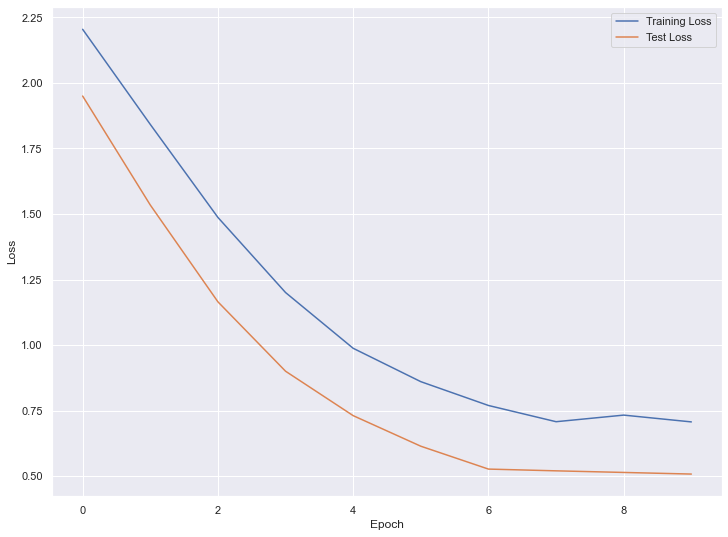

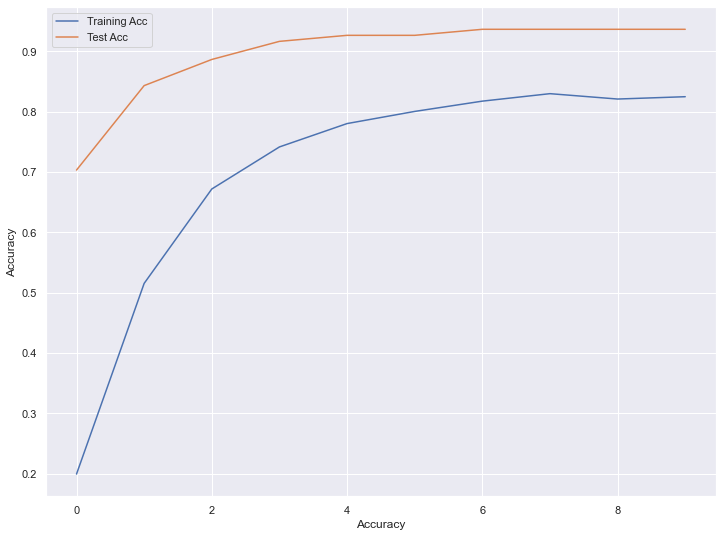

In [8]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize = (12, 9))
ax.plot(train_loss_epoch, label='Training Loss')
ax.plot(test_loss_epoch, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='best')
fig.savefig('loss_inception_net.png', dpi=300)

fig1, ax1 = plt.subplots(1, 1, figsize = (12, 9))
ax1.plot(train_accuracy, label='Training Acc')
ax1.plot(test_accuracy, label='Test Acc')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')
fig1.savefig('accuracy_inception_net.png', dpi=300)

In [6]:
inputs.shape

torch.Size([10, 3, 299, 299])

In [7]:
targets.shape

torch.Size([10])

In [8]:
output.shape

torch.Size([10, 2])

In [17]:
import os

In [33]:
y_pred = []
y_test = []
with torch.set_grad_enabled(False):
    for i, (images, labels) in enumerate(test_loader):
        inputs_test = images.to(device)
        targets_test = labels.to(device)

        output = transfer_model(inputs_test)
        # Compute cross entropy loss
        loss_test = criterion(output, targets_test)
        _, pred = torch.max(output, 1)
        test_acc += torch.sum(targets_test == pred)
        test_loss.append(loss_test.detach().cpu().numpy())
        labels_list = labels.numpy().tolist()
        output_list = pred.detach().cpu().numpy().tolist()
        y_pred.extend(output_list)
        y_test.extend(labels_list) 

In [32]:
pred.detach().cpu().numpy().tolist()

[9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

In [38]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [40]:
class2idx = train_loader.dataset.class_to_idx

In [41]:
idx2class = {value:key for key, value in class2idx.items()}

In [42]:
idx2class

{0: 'Black-Drongo',
 1: 'Black-headed-Munia',
 2: 'Great-Hornbill',
 3: 'Himalayan-Monal',
 4: 'House-Crow',
 5: 'House-Sparrow',
 6: 'Indian-Robin',
 7: 'Red-billed-blue-Magpie',
 8: 'Rufous-Treepie',
 9: 'Scaly-breasted-Munia'}

In [47]:
cm = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[27  0  0  0  1  0  2  0  0  0]
 [ 0 29  0  0  0  0  1  0  0  0]
 [ 0  0 29  0  0  0  0  0  1  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 2  0  0  0 27  0  0  0  1  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 1  1  0  0  0  0 28  0  0  0]
 [ 4  0  1  0  0  0  0 24  1  0]
 [ 0  0  1  0  0  0  1  0 28  0]
 [ 0  0  0  0  0  1  0  0  0 29]]


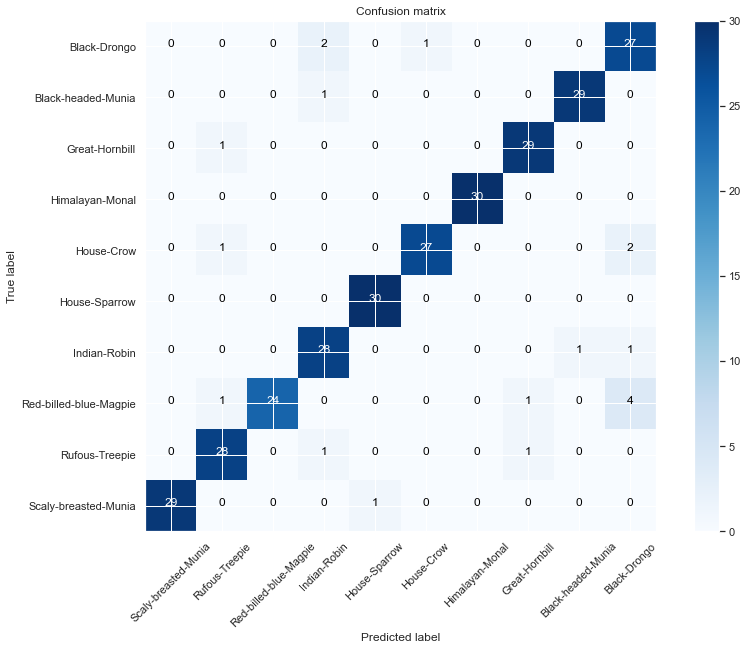

In [48]:
plot_confusion_matrix(cm, idx2class.values())

In [49]:
y_pred = []
y_test = []
with torch.set_grad_enabled(False):
    for i, (images, labels) in enumerate(train_loader):
        inputs_test = images.to(device)
        targets_test = labels.to(device)

        output = transfer_model(inputs_test)
        # Compute cross entropy loss
        loss_test = criterion(output, targets_test)
        _, pred = torch.max(output, 1)
        test_acc += torch.sum(targets_test == pred)
        test_loss.append(loss_test.detach().cpu().numpy())
        labels_list = labels.numpy().tolist()
        output_list = pred.detach().cpu().numpy().tolist()
        y_pred.extend(output_list)
        y_test.extend(labels_list) 

Normalized confusion matrix
[[0.8641115  0.         0.01045296 0.00348432 0.03484321 0.00348432
  0.07665505 0.00348432 0.00348432 0.        ]
 [0.00858369 0.90987124 0.         0.         0.         0.01287554
  0.03004292 0.         0.03433476 0.00429185]
 [0.01764706 0.         0.97058824 0.         0.         0.
  0.         0.         0.01176471 0.        ]
 [0.         0.         0.         0.98518519 0.         0.00740741
  0.         0.00740741 0.         0.        ]
 [0.0648855  0.         0.         0.         0.89694656 0.
  0.02290076 0.01145038 0.00381679 0.        ]
 [0.         0.         0.         0.         0.         0.992
  0.         0.         0.004      0.004     ]
 [0.04745763 0.01355932 0.         0.00338983 0.02372881 0.00677966
  0.89152542 0.00338983 0.01016949 0.        ]
 [0.03900709 0.0106383  0.02836879 0.         0.0035461  0.0212766
  0.0070922  0.86524823 0.0177305  0.0070922 ]
 [0.03162055 0.03162055 0.00395257 0.00395257 0.00395257 0.01185771
  0.00

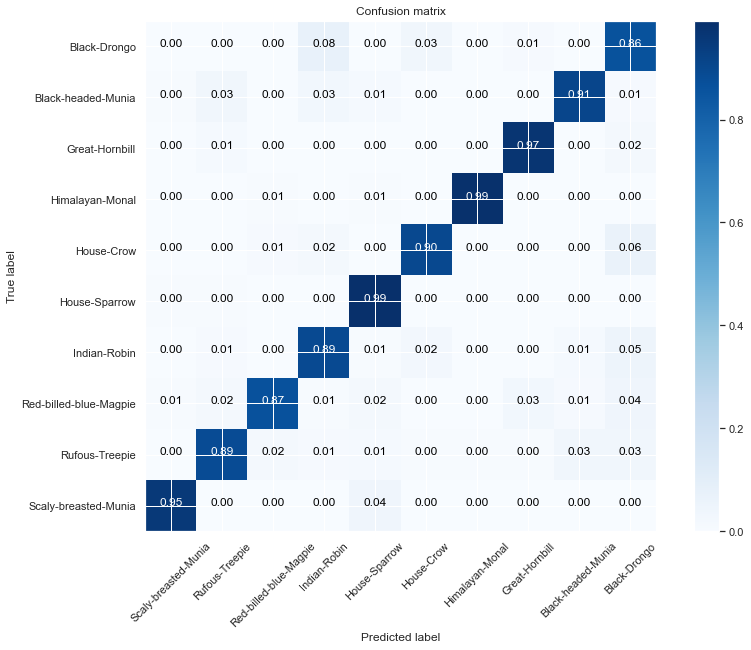

In [51]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, idx2class.values(), normalize=True)